# Computing minimum spotted areas via flux deficit

In [32]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.ndimage import median_filter as medfilt

import sys
sys.path.insert(0, '../')

In [65]:
# Smooth the Kepler-296 and Kepler-62 LCs over one full day
n_cadences = int(24 * 60 * 0.5) # One day
print(n_cadences)

720


In [72]:
def median_filter(x, n_cadences=n_cadences):
    return medfilt(x, (n_cadences, ))

In [79]:
import kplr
client = kplr.API()

names = ['Kepler-296', 'Kepler-62']
kois = [1422, 701]

data = []

for koi_number in kois:
    # Find the target KOI.
    koi = client.koi(koi_number + 0.01)

    # Get a list of light curve datasets.
    lcs = koi.get_light_curves(short_cadence=False)

    # Loop over the datasets and read in the data.
    time, flux, ferr, quality = [], [], [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            time.append(hdu_data["time"])
            flux.append(hdu_data["sap_flux"])
            ferr.append(hdu_data["sap_flux_err"])
            quality.append(hdu_data["sap_quality"])
            
    for time_q, flux_q in zip(time, flux): 
        flux_q /= np.nanmedian(flux_q)
        not_nans = ~np.isnan(flux_q)
        p = np.polyfit(time_q[not_nans], flux_q[not_nans], 2)
        flux_q += 1 - np.polyval(p, time_q)

    flux = median_filter(np.concatenate(flux))
    not_nans = ~np.isnan(flux)
    data.append([np.concatenate(time)[not_nans], flux[not_nans]/np.nanmax(flux)])

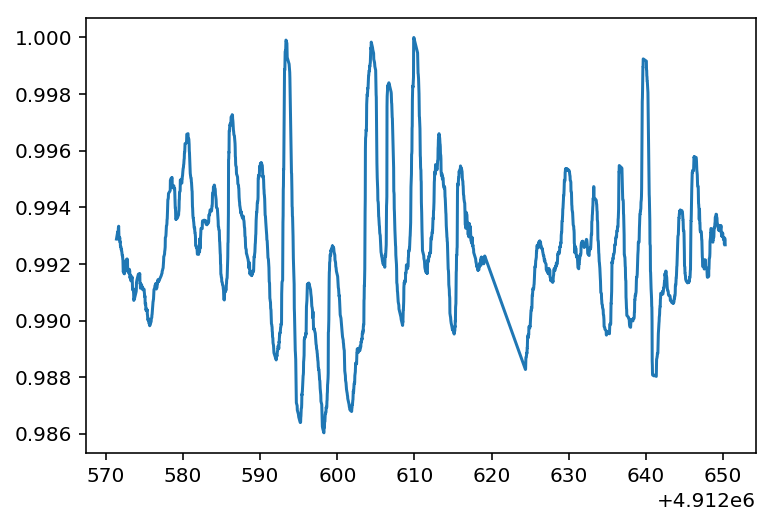

In [75]:
from astropy.utils.data import download_file
from astropy.io import fits

p = download_file('https://github.com/rodluger/trappist1/raw/master/output/nPLDTrappist.fits')
f = fits.getdata(p)
bjd_offset = 2454833.0
not_nans = ~np.isnan(f['FLUX'])
time = f['TIME'][not_nans] + bjd_offset
flux = f['FLUX'][not_nans] / np.median(f['FLUX'][not_nans])

condition = (flux > 0.95) & (flux < 1.2) 

plt.figure()

filtered_time = time[condition] + bjd_offset
# Smooth the TRAPPIST-1 LC over only 50 fluxes
filtered_flux = median_filter(flux[condition], n_cadences=50)

# Remove quadratic

p = np.polyfit((filtered_time - filtered_time.mean()), filtered_flux, 4)
fit = np.polyval(p, (filtered_time - filtered_time.mean()))

filtered_flux += 1 - fit

trappist1 = [filtered_time, filtered_flux/filtered_flux.max()]
plt.plot(*trappist1)

In [80]:
kepler296 = data[0]
kepler62 = data[1]

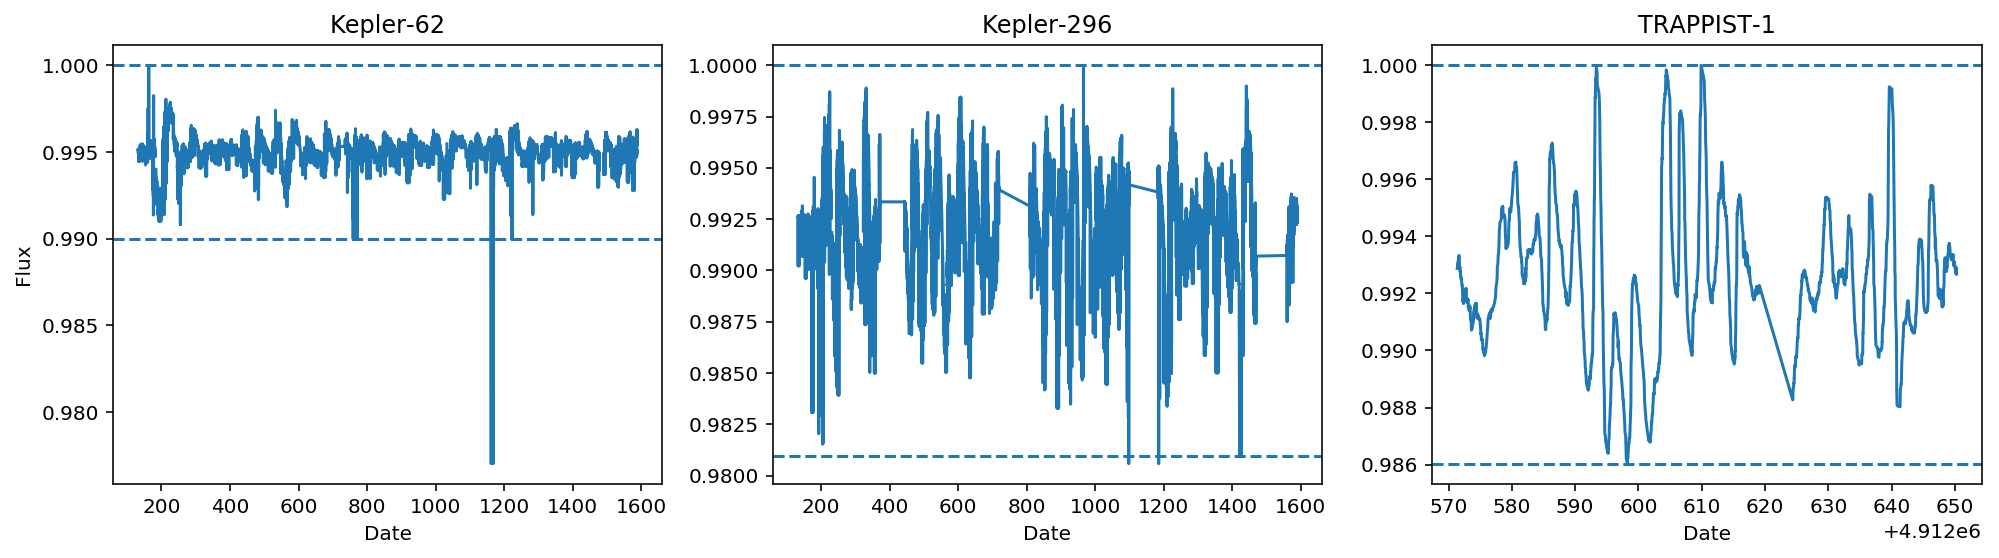

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

min_fluxes = []

names = ['Kepler-62', 'Kepler-296', 'TRAPPIST-1']
for i, target, name in zip(range(3), 
                           [kepler62, kepler296, trappist1], 
                           names):
    time, flux = target
    low_flux = np.percentile(flux, 0.01)
    min_fluxes.append(low_flux)
    ax[i].plot(time, flux)
    ax[i].axhline(1, ls='--')
    ax[i].axhline(low_flux, ls='--')
    ax[i].set_xlabel('Date')
    ax[i].set_title(name)

ax[0].set_ylabel('Flux')
fig.tight_layout()

The minimum fractional spotted area during each quarter is given by 
$$f_{S,\min} = (1 - \min(\mathrm{flux})) (1 - c)$$

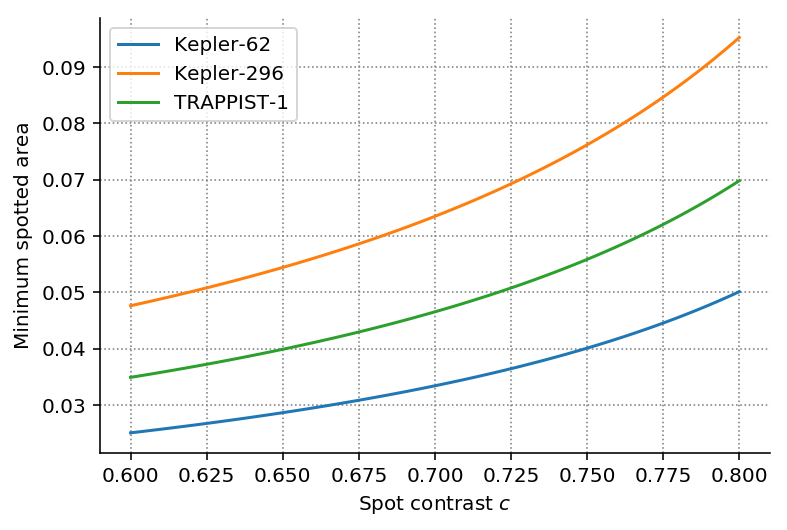

In [93]:
c = np.linspace(0.6, 0.8, 100)

fig, ax = plt.subplots()
for i, mf, name in zip(range(3), min_fluxes, names): 
    spot_frac = (1 - mf)/(1 - c)
    ax.plot(c, spot_frac, label=name)
ax.legend()
ax.set_xlabel('Spot contrast $c$')
ax.set_ylabel('Minimum spotted area')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(ls=':', color='gray')
fig.savefig('flux_deficits.pdf', bbox_inches='tight')